# Stanton Murillo Transport Validation and Improved XC Correction

[1] "Ionic transport in high-energy-density matter"  [10.1103/PhysRevE.93.043203](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.93.043203)

[2]"Efficient model for electronic transport in high energy-density matter "  [https://doi.org/10.1063/5.0048162](https://doi.org/10.1063/5.0048162)

[3]"Rapid ..." [https:...]

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pandas import read_csv

import SMT.core.transport as SMT
from SMT.core.physical_constants import *
from SMT.core.physical_parameters import rs_from_n

import matplotlib.pyplot as plt
import matplotlib as mpl

from cycler import cycler


mpl.rcParams['lines.linewidth'] = 2.2
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['font.sans-serif'] = ['Arial', 'Tahoma', 'DejaVu Sans', 'Lucida Grande', 'Verdana']
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.grid'] = True
mpl.rcParams['grid.color'] = '#636363'
mpl.rcParams['grid.alpha'] = 0.12
mpl.rcParams['grid.linewidth'] = 0.7
mpl.rcParams['grid.linestyle'] = '-'
mpl.rcParams['axes.prop_cycle'] = cycler('color',  ['#0AB34F', '#bf009f', '#00abc3', '#8e92c5', '#cc7014', '#e32851'])
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.framealpha'] = 0.6
mpl.rcParams['legend.fontsize'] = 10
mpl.rcParams['figure.figsize'] = 8, 4.9443
mpl.rcParams['figure.dpi'] = 400

## Define Useful transport function

In [5]:
from scipy.interpolate import CubicSpline, PchipInterpolator

def get_transport_functions(Z, A, ni_cc, file, improved=False, plot_Zbar=False):

    if improved==True:
        smt = SMT.TransportProperties(1, np.array([m_amu*A]), np.array([Z]), np.array([1*eV_to_AU, 1*eV_to_AU ]), 
                                  np.array([ni_cc])*invcc_to_AU, improved_xc_SMT=False, improved_ae_SMT=True,improved_λdB_SMT=True ,improved_PauliBlocking=False, Zbar_type='input')
    else:
        smt = SMT.TransportProperties(1, np.array([m_amu*A]), np.array([Z]), np.array([1*eV_to_AU, 1*eV_to_AU ]), 
                                  np.array([ni_cc])*invcc_to_AU, improved_xc_SMT=False, improved_ae_SMT=False,improved_λdB_SMT=False , Zbar_type='input')
    
    GP_df = read_csv(file, delim_whitespace=True)
    # ____ Al ____
    GP_T = GP_df["Te(eV)"].to_numpy()
    GP_Z_bar = GP_df["Z_bar"].to_numpy()

    mid_Z_interp = PchipInterpolator(GP_T, GP_Z_bar, extrapolate=True)
    # Pchip spline
    @np.vectorize
    def Zbar_interp(T_eV):
        if T_eV<np.min(GP_T):
            return GP_Z_bar[0]
        elif T_eV>np.max(GP_T):
            return GP_Z_bar[-1]
        else:
            return mid_Z_interp(T_eV)
        
    # All out in cgs
    if plot_Zbar==True:
        fig, ax = plt.subplots()
        ax.plot(GP_T, GP_Z_bar,'^')
        T_dense = np.geomspace(1e-3,1e6,num=1000)
        ax.plot(T_dense , Zbar_interp(T_dense ),'-')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_ylabel(r'$\bar{Z}$')
        ax.set_xlabel("T[eV]")
    

    @np.vectorize
    def λeff(T_eV):
        T_AU = T_eV*eV_to_AU
        smt.T_array = np.array([T_AU, T_AU])
        smt.Zbar_array = np.array([Zbar_interp(T_eV)])
        return smt.λeff

    @np.vectorize
    def f_dB_ee(T_eV):
        T_AU = T_eV*eV_to_AU
        smt.T_array = np.array([T_AU, T_AU])
        smt.Zbar_array = np.array([Zbar_interp(T_eV)])
        return smt.f_dB_matrix[0,0]
   
    @np.vectorize
    def f_dB_ei(T_eV):
        T_AU = T_eV*eV_to_AU
        smt.T_array = np.array([T_AU, T_AU])
        smt.Zbar_array = np.array([Zbar_interp(T_eV)])
        return smt.f_dB_matrix[0,1]
    
    @np.vectorize
    def f_dB_ii(T_eV):
        T_AU = T_eV*eV_to_AU
        smt.T_array = np.array([T_AU, T_AU])
        smt.Zbar_array = np.array([Zbar_interp(T_eV)])
        return smt.f_dB_matrix[1,1]

    return λeff, f_dB_ee, f_dB_ei, f_dB_ii

# H
Z, A = 1, 1.00784
ρi_gpercc  = 1
ni_cc = ρi_gpercc/(m_amu*A*AU_to_g)
file = "../GP_data/H_combined.dat"

λ_SMT_H = get_transport_functions(Z,A,ni_cc,file,plot_Zbar=False)
λ_mSMT_H = get_transport_functions(Z,A,ni_cc,file,improved=True)

# C
Z, A = 6, 12.011
ρi_gpercc  = 10
ni_cc = ρi_gpercc/(m_amu*A*AU_to_g)
file = "../GP_data/C_combined.dat"

λ_SMT_C = get_transport_functions(Z,A,ni_cc,file,plot_Zbar=False)
λ_mSMT_C = get_transport_functions(Z,A,ni_cc,file,improved=True)

# Al
Z, A = 13, 26.981539
ρi_gpercc  = 2.7
ni_cc = ρi_gpercc/(m_amu*A*AU_to_g)
file = "../GP_data/Al_combined.dat"

λ_SMT_Al = get_transport_functions(Z,A,ni_cc,file,plot_Zbar=False)
λ_mSMT_Al = get_transport_functions(Z,A,ni_cc,file,improved=True)

/home/zach/plasma/SMT/core/physical_parameters.py:19: RuntimeWarning: divide by zero encountered in scalar divide
  θ = Te/Fermi_Energy(ne)
/home/zach/plasma/SMT/core/physical_parameters.py:114: RuntimeWarning: invalid value encountered in scalar subtract
  N = 1 + 2.8343*θ**2 - 0.2151*θ**3 + 5.2759*θ**4
/home/zach/plasma/SMT/core/transport.py:260: RuntimeWarning: invalid value encountered in divide
  self.ri_eff = (3*self._Zbar_array/ (4*π*ρion) )**(1/3)
/home/zach/plasma/SMT/core/transport.py:241: RuntimeWarning: divide by zero encountered in scalar divide
  self.λe = 1/np.sqrt(4*π*self.ne/(self.Te**(9/5) + (2/3*self.EF)**(9/5)  )**(5/9) ) # Option 1 approximation
/home/zach/plasma/SMT/core/transport.py:255: RuntimeWarning: divide by zero encountered in divide
  self.f_dB_matrix = 1 + λdB_matrix**2/rc_matrix**2
/home/zach/plasma/SMT/core/physical_parameters.py:67: RuntimeWarning: divide by zero encountered in scalar power
  return (4/3*π*n)**(-1/3)
/home/zach/plasma/SMT/core/transpor

/home/zach/plasma/SMT/core/physical_parameters.py:19: RuntimeWarning: divide by zero encountered in scalar divide
  θ = Te/Fermi_Energy(ne)
/home/zach/plasma/SMT/core/physical_parameters.py:114: RuntimeWarning: invalid value encountered in scalar subtract
  N = 1 + 2.8343*θ**2 - 0.2151*θ**3 + 5.2759*θ**4
/home/zach/plasma/SMT/core/transport.py:260: RuntimeWarning: invalid value encountered in divide
  self.ri_eff = (3*self._Zbar_array/ (4*π*ρion) )**(1/3)
/home/zach/plasma/SMT/core/transport.py:241: RuntimeWarning: divide by zero encountered in scalar divide
  self.λe = 1/np.sqrt(4*π*self.ne/(self.Te**(9/5) + (2/3*self.EF)**(9/5)  )**(5/9) ) # Option 1 approximation
/home/zach/plasma/SMT/core/transport.py:287: RuntimeWarning: divide by zero encountered in divide
  self.λi_array = 1/np.sqrt(4*π*self._Zbar_array**2*self.ni_array/self.Ti_array)
/home/zach/plasma/SMT/core/transport.py:255: RuntimeWarning: divide by zero encountered in divide
  self.f_dB_matrix = 1 + λdB_matrix**2/rc_matrix

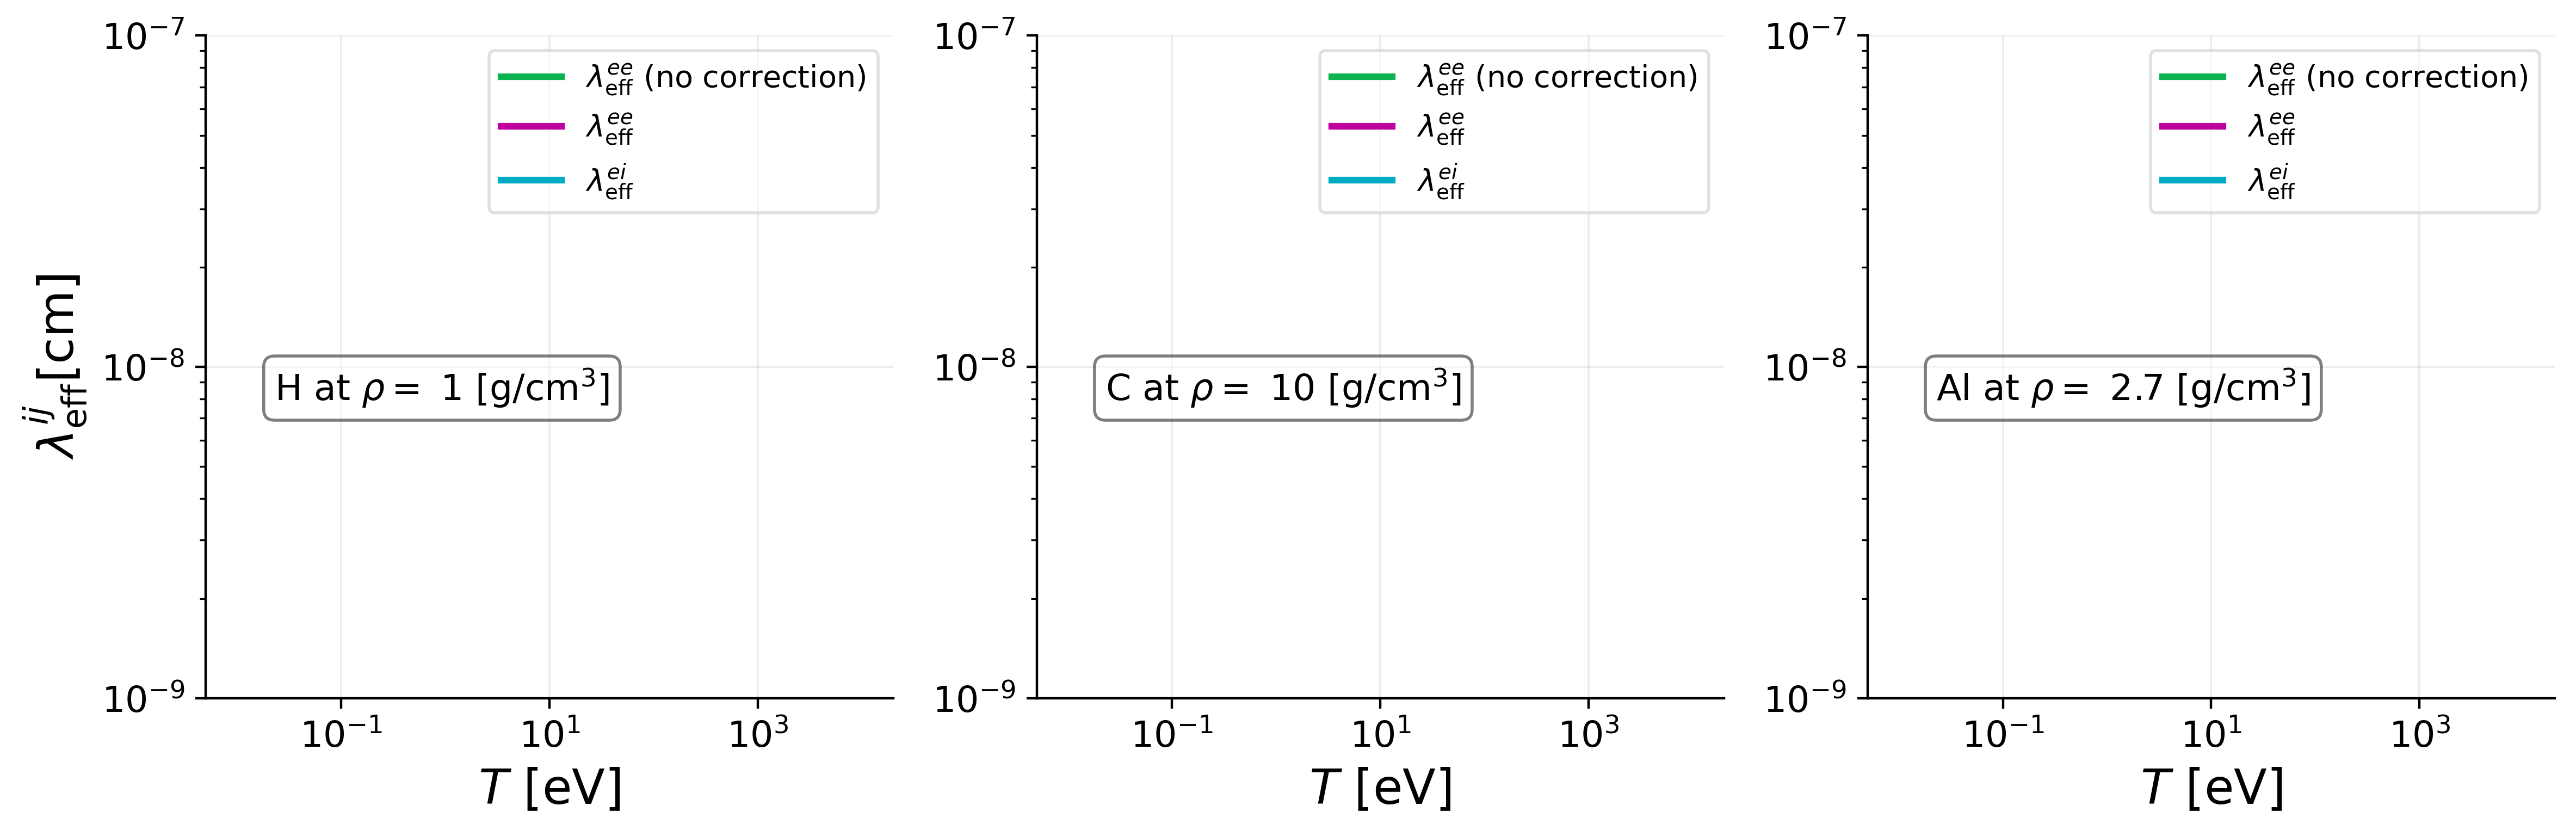

In [6]:
fig, axs = plt.subplots(1,3, figsize=(12,4), facecolor='white')


T_AU_list = np.geomspace(1e-2,1e4,num=100)*eV_to_AU


colors = ['#0AB34F', '#bf009f', '#00abc3', '#8e92c5', '#cc7014', '#e32851']

# H
ax = axs[0]
# λeff = λ_SMT_H[0](T_eV_list)*AU_to_cm
# λ_ee_eff = 1/np.sqrt(λ_mSMT_H[1][0,0]) * λ_mSMT_H[0](T_eV_list)*AU_to_cm
# λ_ei_eff = 1/np.sqrt(λ_mSMT_H[1][0,1]) * λ_mSMT_H[0](T_eV_list)*AU_to_cm

T_eV_list = T_AU_list*AU_to_eV

ax.plot(T_eV_list, λ_SMT_H[0](T_eV_list), color=colors[0], label=r'$\lambda^{ee}_{\rm eff}$ (no correction)')
ax.plot(T_eV_list, λ_mSMT_H[1](T_eV_list) , color=colors[1], linestyle='-', label=r'$\lambda^{ee}_{\rm eff}$')
ax.plot(T_eV_list, λ_mSMT_H[2](T_eV_list) , color=colors[2], linestyle='-', label=r'$\lambda^{ei}_{\rm eff}$')
ax.set_ylabel(r"$\lambda^{ij}_{\rm eff} $[cm]")
# Inset Text Box
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
inset_text = "H at " + r"$\rho=$ 1 [g/cm$^3$]" 
ax.text(0.1, 0.5, inset_text, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)
# C
ax = axs[1]
ax.plot(T_eV_list, λ_SMT_C[0](T_eV_list), color=colors[0], label=r'$\lambda^{ee}_{\rm eff}$ (no correction)')
ax.plot(T_eV_list, λ_mSMT_C[1](T_eV_list) , color=colors[1], linestyle='-', label=r'$\lambda^{ee}_{\rm eff}$')
ax.plot(T_eV_list, λ_mSMT_C[2](T_eV_list) , color=colors[2], linestyle='-', label=r'$\lambda^{ei}_{\rm eff}$')
# Inset Text Box
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
inset_text = "C at " + r"$\rho=$ 10 [g/cm$^3$]" 
ax.text(0.1, 0.5, inset_text, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)
# Al
ax = axs[2]
ax.plot(T_eV_list, λ_SMT_Al[0](T_eV_list), color=colors[0], label=r'$\lambda^{ee}_{\rm eff}$ (no correction)')
ax.plot(T_eV_list, λ_mSMT_Al[1](T_eV_list) , color=colors[1], linestyle='-', label=r'$\lambda^{ee}_{\rm eff}$')
ax.plot(T_eV_list, λ_mSMT_Al[2](T_eV_list) , color=colors[2], linestyle='-', label=r'$\lambda^{ei}_{\rm eff}$')
# Inset Text Box
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
inset_text = "Al at " + r"$\rho=$ 2.7 [g/cm$^3$]" 
ax.text(0.1, 0.5, inset_text, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

for ax in axs:
    ax.set_xlabel(r"$T$ [eV]")
    ax.set_ylim(1e-9,1e-7)
    # ax.set_xlim(5e-2, 1e8)

    # ax.set_ylim(2e-9,1e-7)
    # ax.set_xlim(1,1e4)
    # Scales
    ax.set_yscale('log')
    ax.set_xscale('log')

    # Legend
    ax.legend()

plt.tight_layout()
plt.savefig("λeff_xc_plot.png", dpi=400)


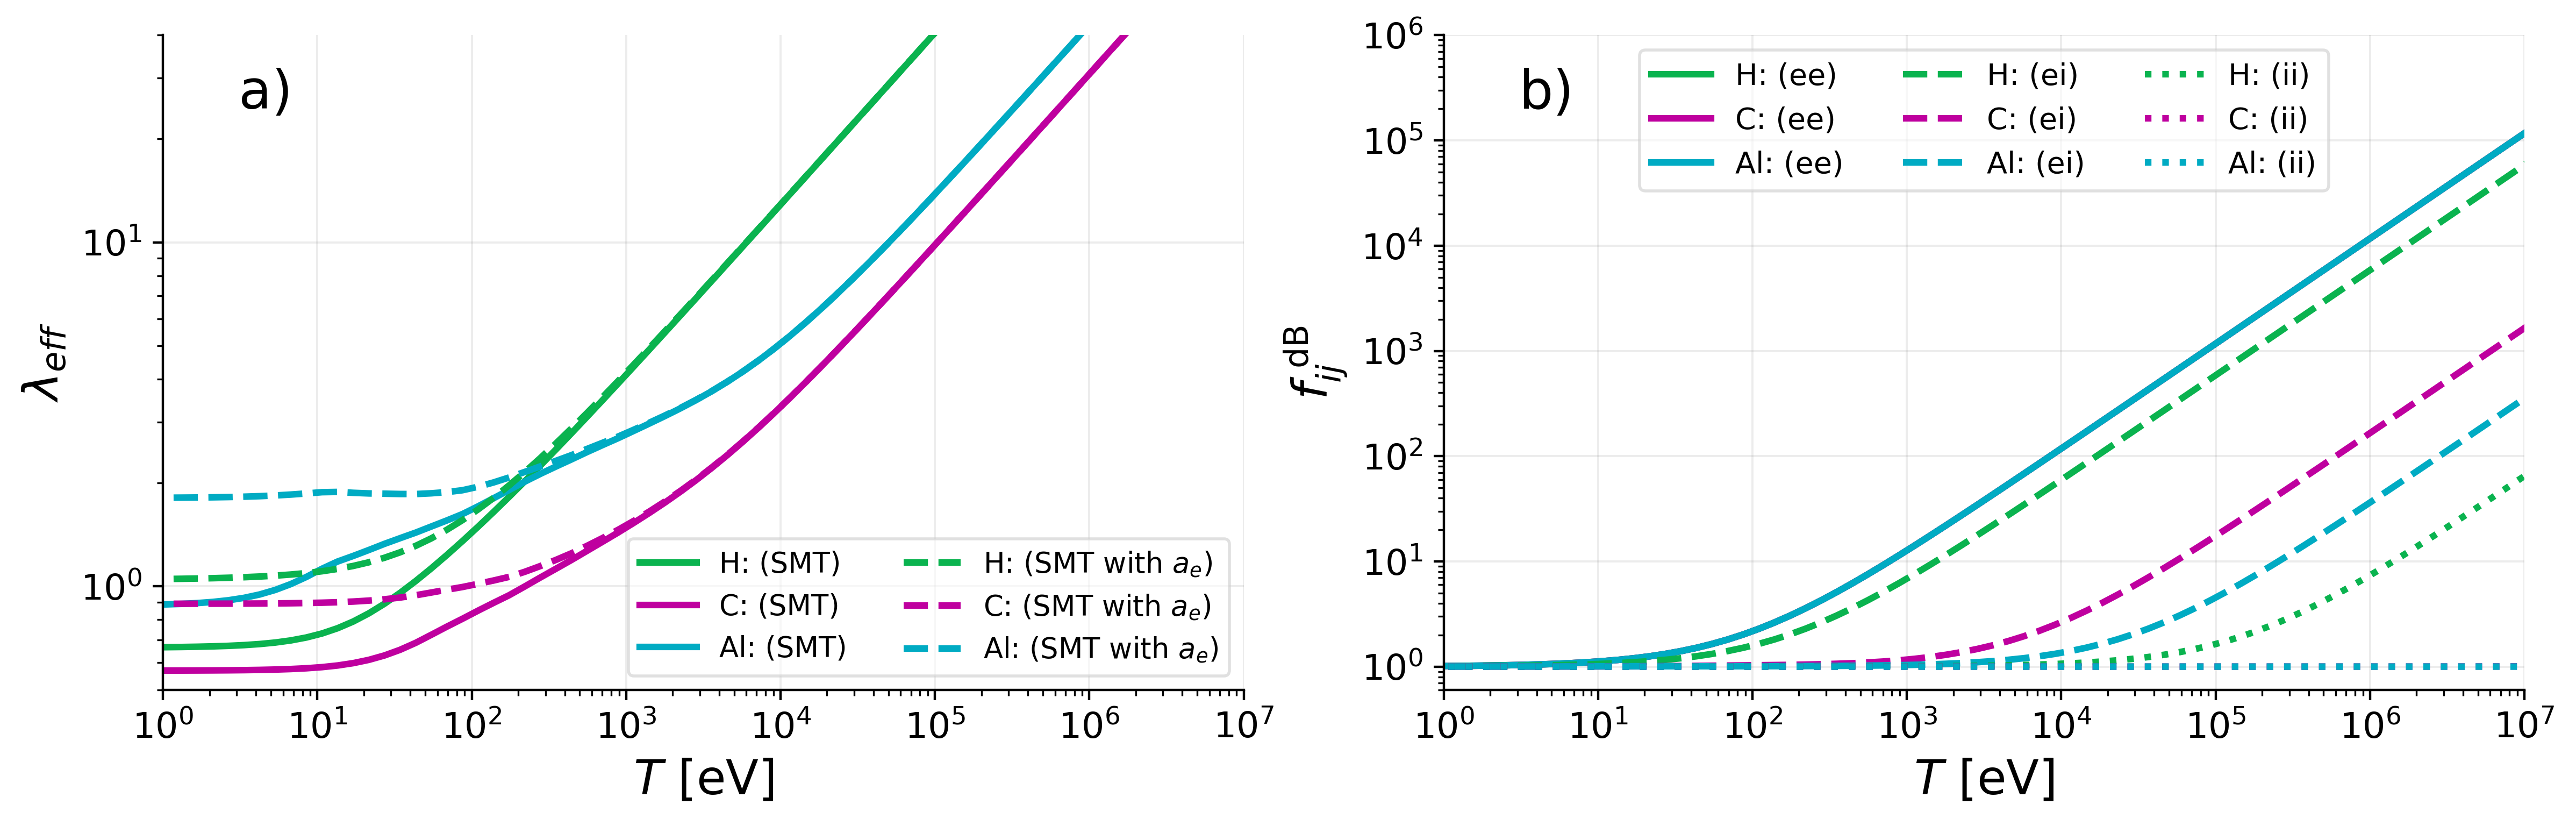

In [21]:
fig, axs = plt.subplots(1,2, figsize=(12,4), facecolor='white')


T_AU_list = np.geomspace(1e-2,1e8,num=100)*eV_to_AU


colors = ['#0AB34F', '#bf009f', '#00abc3', '#8e92c5', '#cc7014', '#e32851']

# H
ax = axs[0]
# λeff = λ_SMT_H[0](T_eV_list)*AU_to_cm
# λ_ee_eff = 1/np.sqrt(λ_mSMT_H[1][0,0]) * λ_mSMT_H[0](T_eV_list)*AU_to_cm
# λ_ei_eff = 1/np.sqrt(λ_mSMT_H[1][0,1]) * λ_mSMT_H[0](T_eV_list)*AU_to_cm

T_eV_list = T_AU_list*AU_to_eV
   
ax.text(0.07, 0.95, "a)", transform=ax.transAxes, fontsize=18,
        verticalalignment='top')#, bbox=props)

ax.plot(T_eV_list, λ_SMT_H[0](T_eV_list), color=colors[0], label=r'H: (SMT)')
ax.plot(T_eV_list, λ_SMT_C[0](T_eV_list), color=colors[1], label=r'C: (SMT)')
ax.plot(T_eV_list, λ_SMT_Al[0](T_eV_list), color=colors[2], label=r'Al: (SMT)')

ax.plot(T_eV_list, λ_mSMT_H[0](T_eV_list), color=colors[0], linestyle='--', label=r'H: (SMT with $a_{e}$)')
ax.plot(T_eV_list, λ_mSMT_C[0](T_eV_list), color=colors[1], linestyle='--', label=r'C: (SMT with $a_{e}$)')
ax.plot(T_eV_list, λ_mSMT_Al[0](T_eV_list), color=colors[2], linestyle='--', label=r'Al: (SMT with $a_{e}$)')
ax.set_ylabel(r"$\lambda_{eff}$")
ax.set_ylim(0.5,40)
ax.legend( ncols=2,loc='lower right',fontsize=9.5)
   
ax = axs[1]
ax.text(0.07, 0.95, "b)", transform=ax.transAxes, fontsize=18,
        verticalalignment='top')#, bbox=props)

ax.plot(T_eV_list, (λ_mSMT_H[1](T_eV_list)), color=colors[0], linestyle='-', label=r'H: (ee)')
ax.plot(T_eV_list, (λ_mSMT_C[1](T_eV_list)), color=colors[1], linestyle='-', label=r'C: (ee)')
ax.plot(T_eV_list, (λ_mSMT_Al[1](T_eV_list)), color=colors[2], linestyle='-', label=r'Al: (ee)')

ax.plot(T_eV_list, (λ_mSMT_H[2](T_eV_list)), color=colors[0], linestyle='--', label=r'H: (ei)')
ax.plot(T_eV_list, (λ_mSMT_C[2](T_eV_list)), color=colors[1], linestyle='--', label=r'C: (ei)')
ax.plot(T_eV_list, (λ_mSMT_Al[2](T_eV_list)), color=colors[2], linestyle='--', label=r'Al: (ei)')

ax.plot(T_eV_list, (λ_mSMT_H[3](T_eV_list)), color=colors[0], linestyle=':', label=r'H: (ii)')
ax.plot(T_eV_list, (λ_mSMT_C[3](T_eV_list)), color=colors[1], linestyle=':', label=r'C: (ii)')
ax.plot(T_eV_list, (λ_mSMT_Al[3](T_eV_list)), color=colors[2], linestyle=':', label=r'Al: (ii)')
ax.set_ylabel(r"$f^{\rm\  dB}_{ij}$")
ax.set_ylim(0.6,1e6)

ax.legend(ncols=3,loc='upper center',fontsize=10)

for ax in axs:
    ax.set_xlabel(r"$T$ [eV]")
    # ax.set_ylim(1e-9,1e-7)
    ax.set_xlim(1, 1e7)

    # ax.set_ylim(2e-9,1e-7)
    # ax.set_xlim(1,1e4)
    # Scales
    ax.set_yscale('log')
    ax.set_xscale('log')

    # Legend

plt.tight_layout()
plt.savefig("λeff_fdB_plot.png", dpi=400)
